In [1]:
# Package Imports
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt

from shapely.geometry import MultiLineString, LineString, Polygon, Point
from shapely import wkt
from shapely.affinity import rotate, scale

import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show

from imp import reload

# to load the interactive plotting version
#%matplotlib widget
# or regular
%matplotlib inline

# Importing my modules
import data_loading, set_cover, plotting, geometry_operations, optimization_functions

/tmp/ipykernel_5825/1584820001.py:18: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


##### Reading the TIF and CSV Data

In [2]:
forest_area_gpd = gpd.GeoDataFrame(pd.DataFrame(
    {"name": ["area1", "area2", "area3", "area4", "area5"]}), 
    geometry=data_loading.read_tif("Resources_Organized/tif/Bestand3.tif"))
#forest_area_gpd.plot()

#load the data and show that we have correctly parsed the CSV
bestand_3_csv = data_loading.read_csv("Resources_Organized/csv/Bestand3_h.csv")
bestand_3_csv = data_loading.format_csv(bestand_3_csv)
bestand_3_csv.head

<bound method NDFrame.head of              x          y       z     id          BHD      h crownLength  \
0   -68.216701  61.395624 -52.341    1.0  56,14971429  38,74       37,64   
1   -42.198416  22.294888 -26.887    2.0            4   9,54           0   
2   -35.660549  48.789428 -39.520    3.0   34,5655619  33,07       15,77   
3   -63.811228  60.685099 -52.156    4.0      32,0572  33,07       10,92   
4   -12.395044  77.242318 -42.336    5.0  38,38882324  24,77           0   
..         ...        ...     ...    ...          ...    ...         ...   
628   4.503100  96.760800 -52.333  640.0         63,8  20,51           0   
629   3.241200  92.597600 -48.579  641.0           10  28,74           0   
630  11.452980  27.791890  -9.873  642.0        44,56   31,1        25,9   
631  10.763840  30.705970 -11.548  643.0        28,66  24,77           0   
632   9.759666  89.327680 -42.205  647.0           10  29,32           0   

    crownArea crownVolume crownDiameter  
0        34,8  

#### Adding trees to the map

<AxesSubplot:xlabel='X coordinate', ylabel='Y coordinate'>

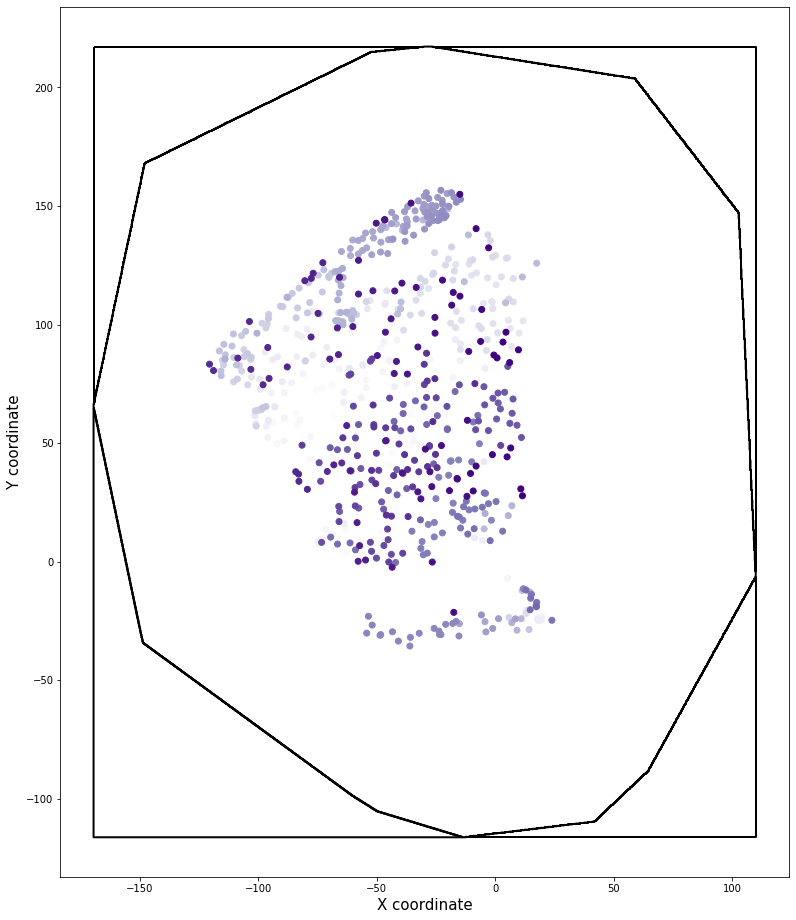

In [3]:
point_list = [Point(xy) for xy in zip(bestand_3_csv["x"], bestand_3_csv["y"])]
tree_gpd = gpd.GeoDataFrame(data=bestand_3_csv,geometry=point_list)

#verify that the boundary and trees add up
fig, ax = plt.subplots(figsize = (20,16))
ax.set_xlabel('X coordinate', fontsize=15)
ax.set_ylabel('Y coordinate', fontsize=15)
tree_gpd.plot(cmap = 'Purples',ax=ax)
forest_area_gpd.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2,ax=ax)

#### Joining and Overlaying Anchor Areas and Road on the Map

Recording coordinates with interactive figure

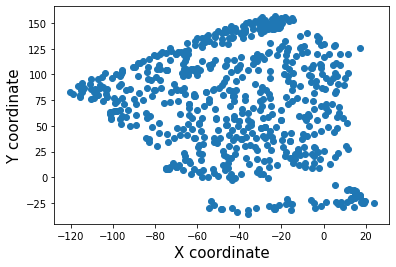

In [4]:
reload(plotting)

coords = []
fig, ax = plt.subplots()
ax.set_xlabel('X coordinate', fontsize=15)
ax.set_ylabel('Y coordinate', fontsize=15)
ax.scatter(tree_gpd["x"],tree_gpd["y"])

cid = fig.canvas.mpl_connect('button_press_event',  lambda event: plotting.onclick(event,coords))

In [5]:
fig.canvas.mpl_disconnect(cid)

Create the extra_geometry_gpd from manual coordinates

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


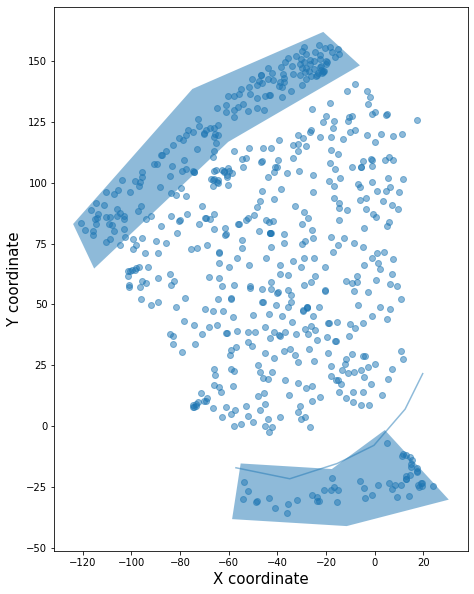

In [6]:
# manually insert those coordinates
# recorded coordinates for the given areas
downhill_anchors = Polygon([Point(xy) for xy in [(-123.88268627035482, 83.05479790035122), (-74.89307684787903, 138.5299549848453), (-21.10056454084676, 161.97821725767267), (-6.051468835903222, 148.2524051955298), (-60.16417466857257, 116.79741921978575), (-115.23746107815322, 64.75371515082742)]])
uphill_anchors = Polygon([Point(xy) for xy in [(-55.04107825837903, -15.31352187833928), (-17.578435758838708, -17.601157222029755), (4.194723984483858, -1.5877098161964227), (30.450593086725803, -30.18315161232738), (-11.49475877173387, -41.04941949485714), (-58.5632070403871, -38.189875315244045)]])
road = LineString([(-57.282432937838706, -17.029248386107135), (-34.86888614324194, -21.604519073488092), (-15.337081079379033, -15.31352187833928), (-0.2879853744354932, -7.878707011345227), (12.51975565104837, 6.990922722642864), (19.884206740701615, 21.86055245663097)])

extra_geometry_gpd = gpd.GeoDataFrame(pd.DataFrame({"name":["uphill_anchors","road","downhill_anchors"],"geometry":[uphill_anchors,road,downhill_anchors]}))

# set the name as index to easily select the geometry
extra_geometry_gpd.set_index("name", inplace = True)
extra_geometry_gpd.loc['road']

plotting.plot_gdfs([tree_gpd,extra_geometry_gpd])



#### Generating Eligible Trees and Road Pathway

Getting the points along the road

/tmp/ipykernel_5825/1820587770.py:5: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  road_points = [road_geometry.interpolate(distance) for distance in distances] + [road_geometry.boundary[1]]


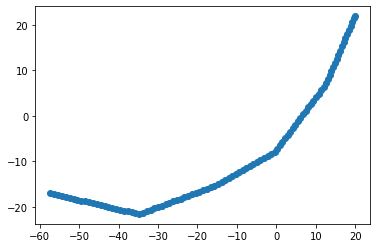

In [7]:
# thanks to https://stackoverflow.com/questions/62990029/how-to-get-equally-spaced-points-on-a-line-in-shapely
road_geometry = extra_geometry_gpd.loc['road'].geometry
distance_delta = 1
distances = np.arange(0, road_geometry.length, distance_delta)
road_points = [road_geometry.interpolate(distance) for distance in distances] + [road_geometry.boundary[1]]

#reset the figure
fig.data = []
plotting.plot_scatter_xy(road_points)

Getting the trees contained in the anchor/target tree polygons

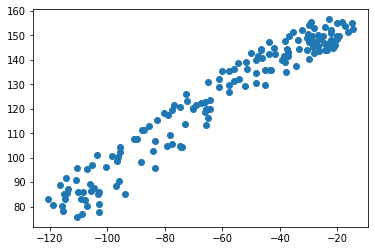

In [8]:
# get the eligible anchor and target trees inside the polygon
uphill_anchor_trees = geometry_operations.get_contained_elements(tree_gpd,extra_geometry_gpd.loc["uphill_anchors"].geometry)
downhill_anchor_trees = geometry_operations.get_contained_elements(tree_gpd,extra_geometry_gpd.loc["downhill_anchors"].geometry)

# and check if the anchor trees look good
plotting.plot_scatter_xy(downhill_anchor_trees)

#### Generating Possible Lines

Setting and rotating the slope line

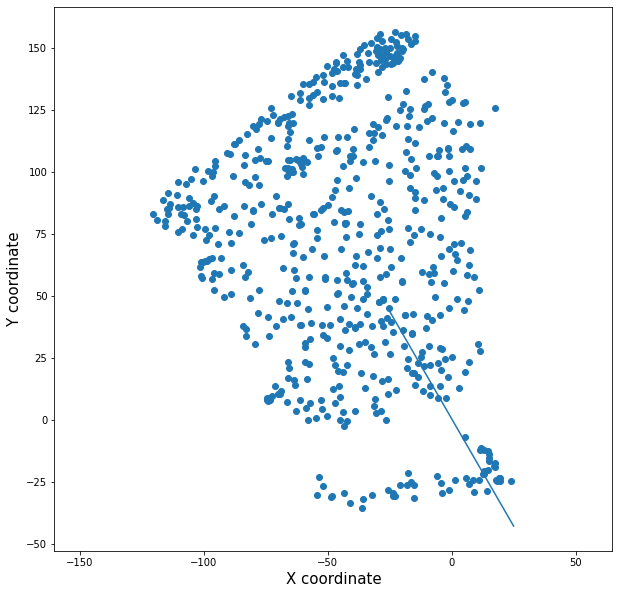

In [9]:
slope_degree = 30
# set a orientation line we can plan the line deviation around
slope_line = LineString([(0,0),(0,1)])
slope_line = rotate(slope_line, slope_degree)

# scale the line by a factor of 100 and plot it
slope_line = scale(slope_line,100,100)

ax = plotting.plot_equal_axis(slope_line)
ax.scatter(bestand_3_csv["x"], bestand_3_csv["y"])

Generating the possible lines depending on the slope

we have n lines:  4618


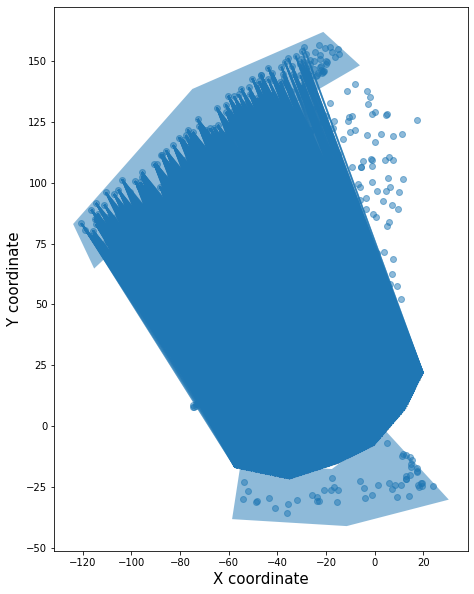

In [10]:
reload(geometry_operations)
max_deviation = 10
possible_lines, slope_deviation = geometry_operations.generate_possible_lines(road_points,downhill_anchor_trees,slope_line, max_deviation)
print("we have n lines: ",len(possible_lines))

line_gdf = gpd.GeoDataFrame(geometry=possible_lines)
#add the length of each line
line_gdf["line_length"] = line_gdf.geometry.length
line_gdf["slope_deviation"] = slope_deviation

plotting.plot_gdfs([tree_gpd,extra_geometry_gpd,line_gdf])

Compute the trees covered by each line

In [11]:
line_gdf.head

<bound method NDFrame.head of                                            geometry  line_length  \
0      LINESTRING (-57.282 -17.029, -97.022 88.550)   112.810242   
1     LINESTRING (-57.282 -17.029, -102.761 77.775)   105.147984   
2     LINESTRING (-57.282 -17.029, -106.929 80.351)   109.305896   
3     LINESTRING (-57.282 -17.029, -107.911 82.709)   111.852578   
4     LINESTRING (-57.282 -17.029, -110.398 75.824)   106.972205   
...                                             ...          ...   
4613    LINESTRING (19.884 21.861, -57.680 127.067)   130.708086   
4614    LINESTRING (19.884 21.861, -50.211 142.732)   139.725159   
4615    LINESTRING (19.884 21.861, -46.549 144.090)   139.116471   
4616    LINESTRING (19.884 21.861, -46.706 144.267)   139.347393   
4617    LINESTRING (19.884 21.861, -35.525 151.196)   140.704465   

      slope_deviation  
0            9.373583  
1            4.372391  
2            2.986418  
3            3.086975  
4            0.228636  
...      

In [12]:
buffer_size = 5
min_trees_covered = 10

reload(geometry_operations)

overall_coverage_series = geometry_operations.compute_points_covered_per_row(
    tree_gpd, line_gdf, buffer_size, min_trees_covered)

# and unzip the results
x,y = zip(*overall_coverage_series)
line_gdf["id_trees_covered"] = list(x)
line_gdf["amount_trees_covered"] = list(y)

In [16]:
line_gdf["buffer"] = line_gdf.apply(
        lambda row: row.geometry.buffer(5), axis=1)

test_buffer = line_gdf.loc[0,"buffer"]
buffer_contains = tree_gpd.geometry.intersects(test_buffer)
true_list, = np.where(buffer_contains)
print(true_list.size)
#print(line_gdf.loc[1,"amount_trees_covered"])


26


In [ ]:
overall_coverage_series.head

<bound method NDFrame.head of 0       ({1.0}, 11)
1       ({1.0}, 11)
2       ({1.0}, 11)
3       ({1.0}, 11)
4       ({1.0}, 11)
           ...     
4613    ({1.0}, 11)
4614    ({1.0}, 11)
4615    ({1.0}, 11)
4616    ({1.0}, 11)
4617    ({1.0}, 11)
Name: buffer, Length: 4618, dtype: object>

Compute the cost function per line

In [20]:
#line_gdf["line_length"] = line_gdf.geometry.length
line_gdf["buffer_width"] = [buffer_size]*len(line_gdf)

#x0 = buffer size
#x1 = line length
#x2 = slope_deviation
#x3 = trees_covered
def cost_function(x0,x1):
    return (x0-10)**2+(x1-30)#+x2**2
    
line_gdf["line_cost"] = cost_function(line_gdf["buffer_width"],line_gdf["line_length"])

#and set each line as active for later optimization process
line_gdf["line_active"] = 1

#### Apply Optimization on a per-line level

#### Set Covering Problem

Find the (one) optimal configuration of subsets covering the widest area of the forest

102  trees have not been covered


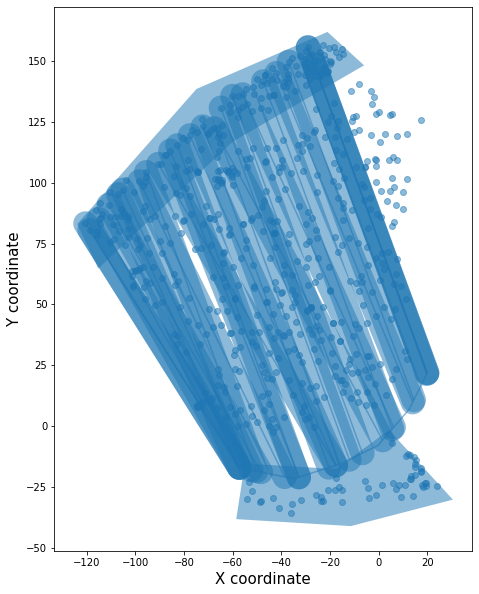

In [13]:
trees_covered_by_line_set = [set(x) for x in line_gdf["id_trees_covered"]]
covered_set = set_cover.set_cover(set(tree_gpd["id"]),trees_covered_by_line_set)
# find the corresponding lines in the df and filter the df by that, so to leave only those lines
covered_lines_gdf = line_gdf[line_gdf["id_trees_covered"].isin(covered_set)]
# and get their boundings boxes to plot them later
bb_covered_lines_gdf = gpd.GeoDataFrame(geometry=covered_lines_gdf["buffer"])

# and plot it
plotting.plot_gdfs([tree_gpd,extra_geometry_gpd,covered_lines_gdf,bb_covered_lines_gdf])

#### MILP Optimization

In [122]:
# set the index of the line_gdf explicitly to make sure we have our x_j
line_gdf['index_column'] = line_gdf.index

# Generate a numpy array from the line_gdf which can be parsed by PYMOO
columns_array = line_gdf[['line_length', 'slope_deviation','amount_trees_covered', 'buffer_width', 'line_cost',
       'line_active','id_trees_covered',"index_column"]].to_numpy()

In [121]:
line_gdf.columns

Index(['geometry', 'line_length', 'slope_deviation', 'buffer',
       'id_trees_covered', 'amount_trees_covered', 'buffer_width', 'line_cost',
       'line_active', 'index_column'],
      dtype='object')

#### Computing the Constraints

We have to constrain the problem to enforce that the set of trees is actually covered

In [140]:
constraint_list = []
highest_tree_id = max(line_gdf["id_trees_covered"].max()).astype(int)

# for each tree id
for id in range(0,highest_tree_id):
    # get the index of this line
    # if the tree id is in the trees covered by this line
    # add the list of line ids that cover this tree id as set to the constraint list
    constraint_list.append({index_column if id in id_trees_covered else None for index_column, id_trees_covered in zip(line_gdf["index_column"],line_gdf["id_trees_covered"])})

In [107]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_termination
from pymoo.optimize import minimize
from pyparsing import line

reload(optimization_functions)

class LineOptimizationProblem(ElementwiseProblem):

#'line_length'      = 0
#'slope_deviation'  = 1
#'amount_trees_covered' = 2, 
#'buffer_width'     = 3, 
#'line_cost'        = 4
#'line_active'      = 5

    def __init__(self):
        super().__init__(n_var=6,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([0, 0, 0, 0, 0, 0]),  # lower bounds
                         xu=np.array([200, 100, 20, 200, 200, 200]))  # upper bounds

    def _evaluate(self, columns_array, out, *args, **kwargs):
        f1 = optimization_functions.line_cost_function(columns_array[3], columns_array[0], columns_array[1], columns_array[5])
        f2 = optimization_functions.tree_coverage_function(columns_array[2], columns_array[5])

        out["F"] = [f1, f2]
        out["G"] = []


algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)

problem = LineOptimizationProblem()
termination = get_termination("n_gen", 40)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F


n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      40 |       5 |            - |            -
    2 |      50 |       5 |  0.014423392 |        ideal
    3 |      60 |       4 |  0.012049169 |            f
    4 |      70 |       3 |  0.252842856 |        nadir
    5 |      80 |       4 |  0.079714474 |            f
    6 |      90 |       5 |  0.005118770 |            f
    7 |     100 |       5 |  0.068806856 |            f
    8 |     110 |       7 |  0.006197399 |        nadir
    9 |     120 |      10 |  0.507743884 |        nadir
   10 |     130 |      11 |  0.000331272 |            f
   11 |     140 |       8 |  1.694803479 |        nadir
   12 |     150 |      11 |  0.042214861 |            f
   13 |     160 |      11 |  0.014016785 |            f
   14 |     170 |       3 |  0.089620990 |        ideal
   15 |     180 |       3 |  0.092920499 |            f
   16 |     190 |       4 |  0.238962588 |        ideal
   17 |     200 |       5 |  0.115153106 |      

In [115]:
F

array([[-5081.51132948, -3761.69548951],
       [-4023.33756365, -3979.13179647],
       [-5185.62293973, -3136.77584417],
       [-5752.00334131, -3064.77832101],
       [-3939.81972624, -3993.05808906]])

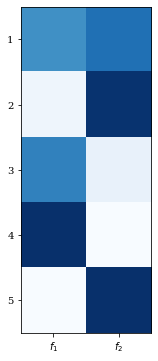

In [112]:
from pymoo.visualization.petal import Petal
Petal(bounds=[0, 1]).add(F).show()

from pymoo.visualization.heatmap import Heatmap
Heatmap().add(F).show()


Scale f1: [0.0, 1.0]
Scale f2: [0.0, 1.0]


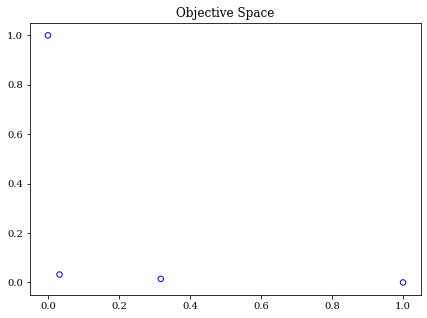

In [44]:
#Normalized Pareto-Optimal Solution
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
fl = nF.min(axis=0)
fu = nF.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")

plt.figure(figsize=(7, 5))
plt.scatter(nF[:, 0], nF[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

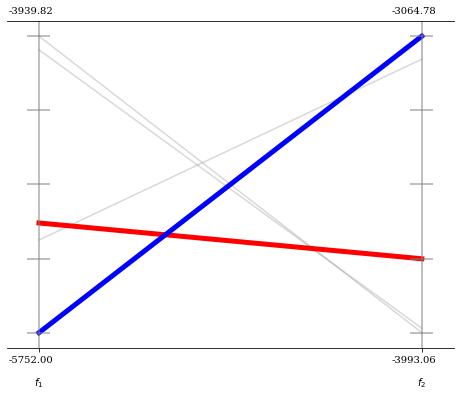

In [108]:
from pymoo.visualization.pcp import PCP
plot = PCP()
plot.set_axis_style(color="grey", alpha=0.5)
plot.add(F, color="grey", alpha=0.3)
plot.add(F[0], linewidth=5, color="red")
plot.add(F[3], linewidth=5, color="blue")
plot.show()

In [33]:
plt.close()

In [116]:
from scipy.optimize import minimize
from numpy.random import rand
 
# objective function
def objective(x):
	return x[0]**2.0 + x[1]**2.0
 
# define range for input
r_min, r_max = -5.0, 5.0
# define the starting point as a random sample from the domain
pt = r_min + rand(2) * (r_max - r_min)
# perform the search
result = minimize(objective, pt, method='nelder-mead')
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : Optimization terminated successfully.
Total Evaluations: 82
Solution: f([-2.10725028e-05  6.51916437e-07]) = 0.00000


#### PySAL LSCP

Back to start - framing our problem via PySAL - https://pysal.org/spopt/notebooks/lscp.html

Variables:
L = potential facility sites = potential lines = name/store
D = set of demand points that must be serviced = trees = destination_name
F = subset of L that minimizes distance from D to next facility

Prerequisites:
1. Compute distance from all lines to all points -> network_distance
2. List of demand points = demand_points = trees
3. List of facilities = facility_points = lines

In [24]:
line_gdf.size*tree_gpd.size

289396206

In [ ]:
#create df with nrow = nlinexs*ntrees
distances_df = pd.DataFrame(columns = ['LineID', 'TreeID', 'Distance'])

for i in range (0,line_gdf.size*tree_gpd.size):
#for line in linegdf:
#    df[lineid, treeid]. distance = 


In [15]:
import numpy
import geopandas
import pandas
import pulp
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [ ]:
CLIENT_COUNT = 100 # quantity demand points
FACILITY_COUNT = 5 # quantity supply points

SERVICE_RADIUS = 15 # maximum service radius in meters

# Random seeds for reproducibility
CLIENT_SEED = 5
FACILITY_SEED = 6

solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)
